In [8]:
%pip install bokeh
%pip install calplot
%pip install mpld3

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [9]:
import pandas as pd
import numpy as np
from bokeh.models import ColumnDataSource
from bokeh.plotting import figure, show
from bokeh.models.ranges import FactorRange
import matplotlib.pyplot as plt
import mpld3
import re
import folium

In [10]:
# Read SF Police data
data_all = pd.read_csv("Data.csv") 

In [11]:
#data = (data_all[data_all['Category']=='SEX OFFENSES, FORCIBLE'] ) 

#selecting data for crime categories related to SEX OFFENSES 
data=data_all.iloc[np.where((data_all['Category'] == 'SEX OFFENSES, FORCIBLE') | (data_all['Category'] == 'SEX OFFENSES, NON FORCIBLE'))[0]]

/tmp/ipykernel_23602/1525337123.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Date'] = pd.to_datetime(data.Date, format='%m/%d/%Y')
/tmp/ipykernel_23602/1525337123.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Year'] = data.Date.dt.year
/tmp/ipykernel_23602/1525337123.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

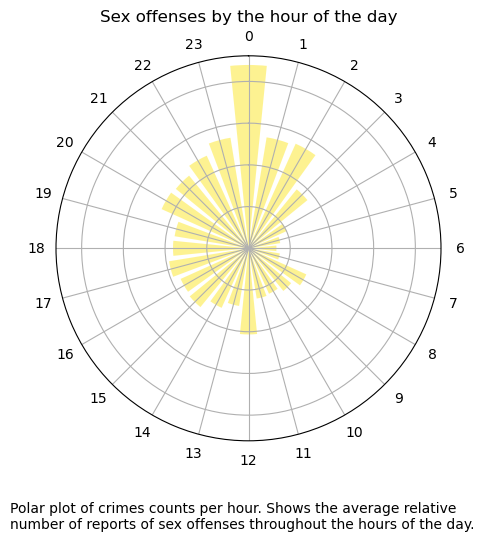

In [12]:
# Create structure of plot
N = 24 # 24 hours
theta = np.linspace(0.0, 2 * np.pi, N, endpoint=False)
#width = np.pi / 4 * np.random.rand(N)
width = 0.2
# Make hour column in dataframe, filter data by robbery
data['Date'] = pd.to_datetime(data.Date, format='%m/%d/%Y')
data['Year'] = data.Date.dt.year
data['Time'] = pd.to_datetime(data.Time, format='%H:%M')
data['Hour'] = data.Time.dt.hour

# Count the data by hour
radii = data.groupby('Hour')['PdId'].count()

# Plot polar plot
fig = plt.figure(figsize=(5,5))
ax = plt.subplot(projection='polar')
ax.bar(theta, radii, width=width, bottom=0.0, color=plt.cm.viridis(radii / 10.), alpha=0.5)
ax.set_xticks(theta)
ax.set_xticklabels(range(24))
ax.set_yticklabels([])
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

plt.title('Sex offenses by the hour of the day')
txt = 'Polar plot of crimes counts per hour. Shows the average relative\nnumber of reports of sex offenses throughout the hours of the day.' # It is clear that most crimes \noccur during the early night, from 23 to 1. Surprisingly, there are few crimes happening in the middle of the night, probably due to a lower amount of police officers.'
plt.figtext(0.5, -0.06, txt, wrap=True, horizontalalignment='center', multialignment='left', fontsize=10);

In [13]:
html = mpld3.fig_to_html(fig)
with open('polarplot.html', 'w') as f:
    f.write(html)

fig.savefig('polarplot.png')

## Map

In [14]:
df_clubs=pd.read_csv('Registered_Business_Locations_-_San_Francisco.csv')
[n,p]=np.shape(df_clubs)

In [15]:
def extract_coord(x):
    point_string = x

    pattern = r'POINT \((-?\d+\.\d+) (-?\d+\.\d+)\)'
    match = re.match(pattern, point_string)

    longitude = float(match.group(1))
    latitude = float(match.group(2))

    return longitude, latitude

In [16]:
extract_coord_vect=np.vectorize(extract_coord)
[df_clubs['Longitude'],df_clubs['Latitude']]=extract_coord_vect(df_clubs['Business Location'])

In [17]:
map_hooray = folium.Map(location=[ 37.7616,-122.42287],
                    tiles = "Stamen Toner",
                    zoom_start = 12.2)
for i in range(n):
    folium.Marker([df_clubs['Latitude'][i],df_clubs['Longitude'][i]],
            icon=folium.Icon(color='red',icon='none')).add_to(map_hooray)

map_hooray

In [18]:
data_so=data.iloc[np.where((data['Category']== 'SEX OFFENSES, FORCIBLE') | (data['Category']== 'SEX OFFENSES, NON FORCIBLE'))[0]]
data_so=data_so.reset_index().drop(columns=['index'])
#cleaning data
drop_data=np.where(data_so['location']=='POINT (-120.50000000000001 90)')[0]
data_so=data_so.drop(drop_data)
[data_so['Longitude'],data_so['Latitude']]=extract_coord_vect(list(data_so['location']))

In [19]:
from folium.plugins import HeatMap

heat_data = [[row['Latitude'],row['Longitude']] for index, row in data_so.iterrows()]

hm=HeatMap(heat_data).add_to(map_hooray)

# Plot it on the map

map_hooray = folium.Map(location=[ 37.7616,-122.42287],
                    tiles = "Stamen Toner",
                    zoom_start = 12.2)
HeatMap(heat_data,gradient={0.1: 'blue', 0.3: 'lime', 0.5: 'yellow', 0.7: 'orange', 1: 'red'}, 
                min_opacity=0.1, 
                max_opacity=1, 
                radius=50,
                use_local_extrema=False).add_to(map_hooray)

for i in range(n):
    folium.Marker([df_clubs['Latitude'][i],df_clubs['Longitude'][i]],
            icon=folium.Icon(color='red',icon='none')).add_to(map_hooray)

# Display the map
map_hooray

In [20]:
map_hooray.save("map.html")

## Bokeh

In [21]:
data = data_so
data['Date'] = pd.to_datetime(data.Date, format='%m/%d/%Y')
data['Year'] = data.Date.dt.year
data['Time'] = pd.to_datetime(data.Time, format='%H:%M')
data['Hour'] = data.Time.dt.hour
data['dummy'] = 1
data['day_of_week'] = data['Date'].dt.day_name()

In [22]:
df = data[['day_of_week','Hour', 'dummy']].groupby(['day_of_week', 'Hour']).count()
df = df.rename(columns={"dummy": "count"})

df_count = data[['day_of_week', 'dummy']].groupby(['day_of_week']).sum()
df_count = df_count.rename(columns={"dummy": "total_count"})

In [23]:
array = []
for idx in df.index:
    array.append(df.loc[idx][0]/df_count.loc[idx[0]][0])
df['Percent'] = array

df_processed = df['Percent'].unstack(level=0)
src = ColumnDataSource(df_processed)

In [24]:
p = figure(x_range=FactorRange(factors = [str(h) for h in df_processed.index]), title="Crimes per Day", 
           toolbar_location=None, x_axis_label='Hour of the day',y_axis_label='Average Crime Count per Hour', tools="")
           
bar ={}
col = ['lightcoral', 'salmon', 'peachpuff', 'bisque', 'khaki', 'palegreen', 'lightcyan']  #  'lightskyblue', 'cornflowerblue', 'lavender', 'thistle', 'plum', 'palevioletred', 'lightpink']
for indx, i in enumerate(df_processed):

    bar[i] = p.vbar(x='Hour',  
                    top = i, 
                    source = src, 
                    legend_label = i,  
                    muted_alpha = 0, 
                    muted = True,
                    color = col[indx],
                    alpha = 0.7
    ) 
    
p.legend.location = "top_right"
p.legend.click_policy="mute" 
show(p)